# Instagram Brand Perception Map
Create a perception map using CLIP embeddings and UMAP dimensionality reduction.

**Approach:**
- Each folder in `instagram_downloads/` represents a brand (e.g., nike) or self-brand (influencers)
- Each post folder contains images/videos representing that post
- Calculate CLIP embeddings for all media in a post and average them
- For videos: extract 1 frame per second
- Save individual embeddings alongside media files
- Use UMAP to visualize brand positioning in 2D space

In [16]:
# Install required packages
# !pip install torch torchvision transformers pillow numpy umap-learn matplotlib seaborn plotly pandas opencv-python scikit-learn

In [17]:
import os
import json
import numpy as np
from pathlib import Path
from PIL import Image
import cv2
import torch
from transformers import CLIPProcessor, CLIPModel
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from tqdm.auto import tqdm
import pandas as pd
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print("✓ Imports complete")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ Imports complete
PyTorch version: 2.2.0+cu118
CUDA available: True


In [18]:
# Configuration
BASE_DIR = Path("instagram_downloads")
OFFICIAL_AD_DIR = Path("official_ad")
EMBEDDINGS_CACHE_FILE = Path("_embeddings_cache.json")  # Shared cache
POST_EMBEDDINGS_FILE = Path("_post_embeddings.npz")

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load CLIP model
print("Loading CLIP model...")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print("✓ CLIP model loaded")

Using device: cuda
Loading CLIP model...
✓ CLIP model loaded
✓ CLIP model loaded


In [19]:
# Helper functions
def extract_frames_from_video(video_path, fps=1):
    """
    Extract frames from video at specified fps.
    Returns list of PIL Images.
    """
    frames = []
    try:
        cap = cv2.VideoCapture(str(video_path))
        video_fps = cap.get(cv2.CAP_PROP_FPS)
        frame_interval = int(video_fps / fps) if video_fps > 0 else 1
        
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            if frame_count % frame_interval == 0:
                # Convert BGR to RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                pil_image = Image.fromarray(frame_rgb)
                frames.append(pil_image)
            
            frame_count += 1
        
        cap.release()
    except Exception as e:
        print(f"Error extracting frames from {video_path}: {e}")
    
    return frames

def get_clip_embedding(image):
    """
    Get CLIP embedding for a single image.
    Returns numpy array of shape (512,).
    """
    try:
        inputs = processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
        # Normalize embedding
        embedding = image_features.cpu().numpy()[0]
        embedding = embedding / np.linalg.norm(embedding)
        return embedding
    except Exception as e:
        print(f"Error getting embedding: {e}")
        return None

def process_media_file(media_path):
    """
    Process a single media file (image or video) and return its embedding.
    For videos, average embeddings of all extracted frames.
    """
    embeddings = []
    
    if media_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
        # Image file
        try:
            image = Image.open(media_path).convert('RGB')
            embedding = get_clip_embedding(image)
            if embedding is not None:
                embeddings.append(embedding)
        except Exception as e:
            print(f"Error processing image {media_path}: {e}")
    
    elif media_path.suffix.lower() in ['.mp4', '.mov', '.avi']:
        # Video file - extract frames
        frames = extract_frames_from_video(media_path, fps=1)
        for frame in frames:
            embedding = get_clip_embedding(frame)
            if embedding is not None:
                embeddings.append(embedding)
    
    # Average all embeddings from this file
    if embeddings:
        avg_embedding = np.mean(embeddings, axis=0)
        # Normalize
        avg_embedding = avg_embedding / np.linalg.norm(avg_embedding)
        return avg_embedding
    
    return None

print("✓ Helper functions defined")

✓ Helper functions defined


In [20]:
# Scan directory structure
def scan_brands_and_posts():
    """
    Scan instagram_downloads and official_ad directories.
    Returns dict: {brand_name: [post_path1, post_path2, ...]}
    """
    brands_posts = defaultdict(list)
    
    # Scan instagram_downloads (brand/post/media structure)
    if BASE_DIR.exists():
        for brand_dir in BASE_DIR.iterdir():
            if not brand_dir.is_dir() or brand_dir.name.startswith('_'):
                continue
            
            brand_name = brand_dir.name
            for post_dir in brand_dir.iterdir():
                if not post_dir.is_dir():
                    continue
                
                media_files = list(post_dir.glob('*.jpg')) + list(post_dir.glob('*.jpeg')) + \
                             list(post_dir.glob('*.png')) + list(post_dir.glob('*.mp4'))
                
                if media_files:
                    brands_posts[brand_name].append(post_dir)
    
    # Scan official_ad (brand/media structure - each media is a "post")
    if OFFICIAL_AD_DIR.exists():
        for brand_dir in OFFICIAL_AD_DIR.iterdir():
            if not brand_dir.is_dir():
                continue
            
            brand_name = f"{brand_dir.name}_official"
            media_files = [f for f in brand_dir.iterdir() 
                          if f.is_file() and f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.mp4']]
            
            # Each media file is treated as its own post
            for media_file in media_files:
                brands_posts[brand_name].append(media_file)
    
    return brands_posts

brands_posts = scan_brands_and_posts()
print(f"\nFound {len(brands_posts)} brands:")
for brand, posts in sorted(brands_posts.items()):
    print(f"  {brand}: {len(posts)} posts")

total_posts = sum(len(posts) for posts in brands_posts.values())
print(f"\nTotal posts: {total_posts}")


Found 14 brands:
  aeropalmics: 106 posts
  afffirmations: 167 posts
  agatapanucci: 144 posts
  akshii09: 106 posts
  anaasotillo: 177 posts
  antonianocca: 4 posts
  artbutmakeitsports: 1089 posts
  badboyshah: 66 posts
  beamarinx: 92 posts
  beateliljegren: 38 posts
  brettsbites: 514 posts
  iampatcortez: 576 posts
  nike: 423 posts
  nike_official: 235 posts

Total posts: 3737


In [22]:
# Process all posts and calculate embeddings
def process_all_posts(brands_posts, use_cache=True):
    """
    Process all posts and calculate averaged embeddings.
    Saves individual media embeddings alongside files.
    Uses cached embeddings to avoid reprocessing.
    Returns:
    - post_embeddings: dict {(brand, post_id): embedding_array}
    - metadata: list of dicts with brand, post_id, num_media, etc.
    """
    post_embeddings = {}
    metadata = []
    
    # Load cache if exists
    embeddings_cache = {}
    if use_cache and EMBEDDINGS_CACHE_FILE.exists():
        try:
            with open(EMBEDDINGS_CACHE_FILE, 'r') as f:
                cache_data = json.load(f)
                embeddings_cache = {k: np.array(v) for k, v in cache_data.items()}
            print(f"✓ Loaded {len(embeddings_cache)} cached embeddings")
        except Exception as e:
            print(f"Could not load cache: {e}")
    
    total_posts = sum(len(posts) for posts in brands_posts.values())
    
    with tqdm(total=total_posts, desc="Processing posts") as pbar:
        for brand_name, posts in brands_posts.items():
            for post_path in posts:
                # Handle both directory posts and single file posts
                if post_path.is_dir():
                    post_id = post_path.name
                    media_files = list(post_path.glob('item_*.jpg')) + \
                                 list(post_path.glob('item_*.jpeg')) + \
                                 list(post_path.glob('item_*.png')) + \
                                 list(post_path.glob('item_*.mp4'))
                else:
                    # Single file from official_ad
                    post_id = post_path.stem
                    media_files = [post_path]
                
                if not media_files:
                    pbar.update(1)
                    continue
                
                # Process each media file
                media_embeddings = []
                
                for media_file in media_files:
                    # Create cache key (relative to project root)
                    cache_key = str(media_file)
                    
                    # Check if embedding already exists as .npy file
                    embedding_file = media_file.with_suffix('.npy')
                    if embedding_file.exists():
                        try:
                            embedding = np.load(embedding_file)
                            embeddings_cache[cache_key] = embedding
                        except:
                            embedding = None
                    elif cache_key in embeddings_cache:
                        embedding = embeddings_cache[cache_key]
                    else:
                        # Process media file
                        embedding = process_media_file(media_file)
                        if embedding is not None:
                            embeddings_cache[cache_key] = embedding
                    
                    if embedding is not None:
                        media_embeddings.append(embedding)
                        
                        # Save individual embedding
                        if not embedding_file.exists():
                            np.save(embedding_file, embedding)
                
                # Average embeddings for this post
                if media_embeddings:
                    post_embedding = np.mean(media_embeddings, axis=0)
                    post_embedding = post_embedding / np.linalg.norm(post_embedding)
                    
                    post_embeddings[(brand_name, post_id)] = post_embedding
                    
                    metadata.append({
                        'brand': brand_name,
                        'post_id': post_id,
                        'num_media': len(media_embeddings),
                        'post_path': str(post_path)
                    })
                
                pbar.update(1)
    
    # Save cache
    cache_to_save = {k: v.tolist() for k, v in embeddings_cache.items()}
    with open(EMBEDDINGS_CACHE_FILE, 'w') as f:
        json.dump(cache_to_save, f)
    print(f"\n✓ Saved {len(embeddings_cache)} embeddings to cache")
    
    return post_embeddings, metadata

# Process all posts
post_embeddings, metadata = process_all_posts(brands_posts, use_cache=True)
print(f"\n✓ Processed {len(post_embeddings)} posts with embeddings")

Processing posts:   0%|          | 0/3737 [00:00<?, ?it/s]


✓ Saved 13435 embeddings to cache

✓ Processed 3737 posts with embeddings


In [23]:
# Prepare data for UMAP
if not post_embeddings:
    print("❌ No embeddings found. Cannot proceed.")
else:
    # Create embedding matrix
    embedding_matrix = np.array([post_embeddings[key] for key in post_embeddings.keys()])
    brands_list = [key[0] for key in post_embeddings.keys()]
    post_ids_list = [key[1] for key in post_embeddings.keys()]
    
    print(f"Embedding matrix shape: {embedding_matrix.shape}")
    print(f"Number of unique brands: {len(set(brands_list))}")
    
    # Save embeddings for later use
    np.savez(POST_EMBEDDINGS_FILE, 
             embeddings=embedding_matrix,
             brands=brands_list,
             post_ids=post_ids_list)
    print(f"✓ Saved embeddings to {POST_EMBEDDINGS_FILE}")

Embedding matrix shape: (3737, 512)
Number of unique brands: 14
✓ Saved embeddings to _post_embeddings.npz


In [24]:
# Apply UMAP dimensionality reduction
print("Applying UMAP...")

# UMAP parameters
n_neighbors = min(15, len(embedding_matrix) - 1)
min_dist = 0.1

reducer = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=2,
    metric='cosine',
    random_state=42
)

embeddings_2d = reducer.fit_transform(embedding_matrix)
print(f"✓ UMAP complete. 2D embeddings shape: {embeddings_2d.shape}")

Applying UMAP...
✓ UMAP complete. 2D embeddings shape: (3737, 2)
✓ UMAP complete. 2D embeddings shape: (3737, 2)


In [25]:
# Create DataFrame for visualization
df = pd.DataFrame({
    'brand': brands_list,
    'post_id': post_ids_list,
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1]
})

# Add metadata
metadata_df = pd.DataFrame(metadata)
df = df.merge(metadata_df, on=['brand', 'post_id'], how='left')

print(f"DataFrame shape: {df.shape}")
print(f"\nBrand distribution:")
print(df['brand'].value_counts())

DataFrame shape: (3737, 6)

Brand distribution:
brand
artbutmakeitsports    1089
iampatcortez           576
brettsbites            514
nike                   423
nike_official          235
anaasotillo            177
afffirmations          167
agatapanucci           144
aeropalmics            106
akshii09               106
beamarinx               92
badboyshah              66
beateliljegren          38
antonianocca             4
Name: count, dtype: int64


In [26]:
# Calculate brand centroids (average position of all posts per brand)
brand_centroids = df.groupby('brand')[['x', 'y']].mean().reset_index()
brand_centroids.columns = ['brand', 'centroid_x', 'centroid_y']
brand_centroids['post_count'] = df.groupby('brand').size().values

print("Brand centroids:")
print(brand_centroids.head(10))

Brand centroids:
                brand  centroid_x  centroid_y  post_count
0         aeropalmics   -0.758613    9.063883         106
1       afffirmations   10.780864   11.767351         167
2        agatapanucci    0.274184    7.679077         144
3            akshii09    2.212475    4.265166         106
4         anaasotillo    1.196198    7.415120         177
5        antonianocca    0.853243    9.179041           4
6  artbutmakeitsports    3.520992   13.965283        1089
7          badboyshah    0.980607    8.726065          66
8           beamarinx   -0.021955    8.068731          92
9      beateliljegren    0.844175    6.283949          38


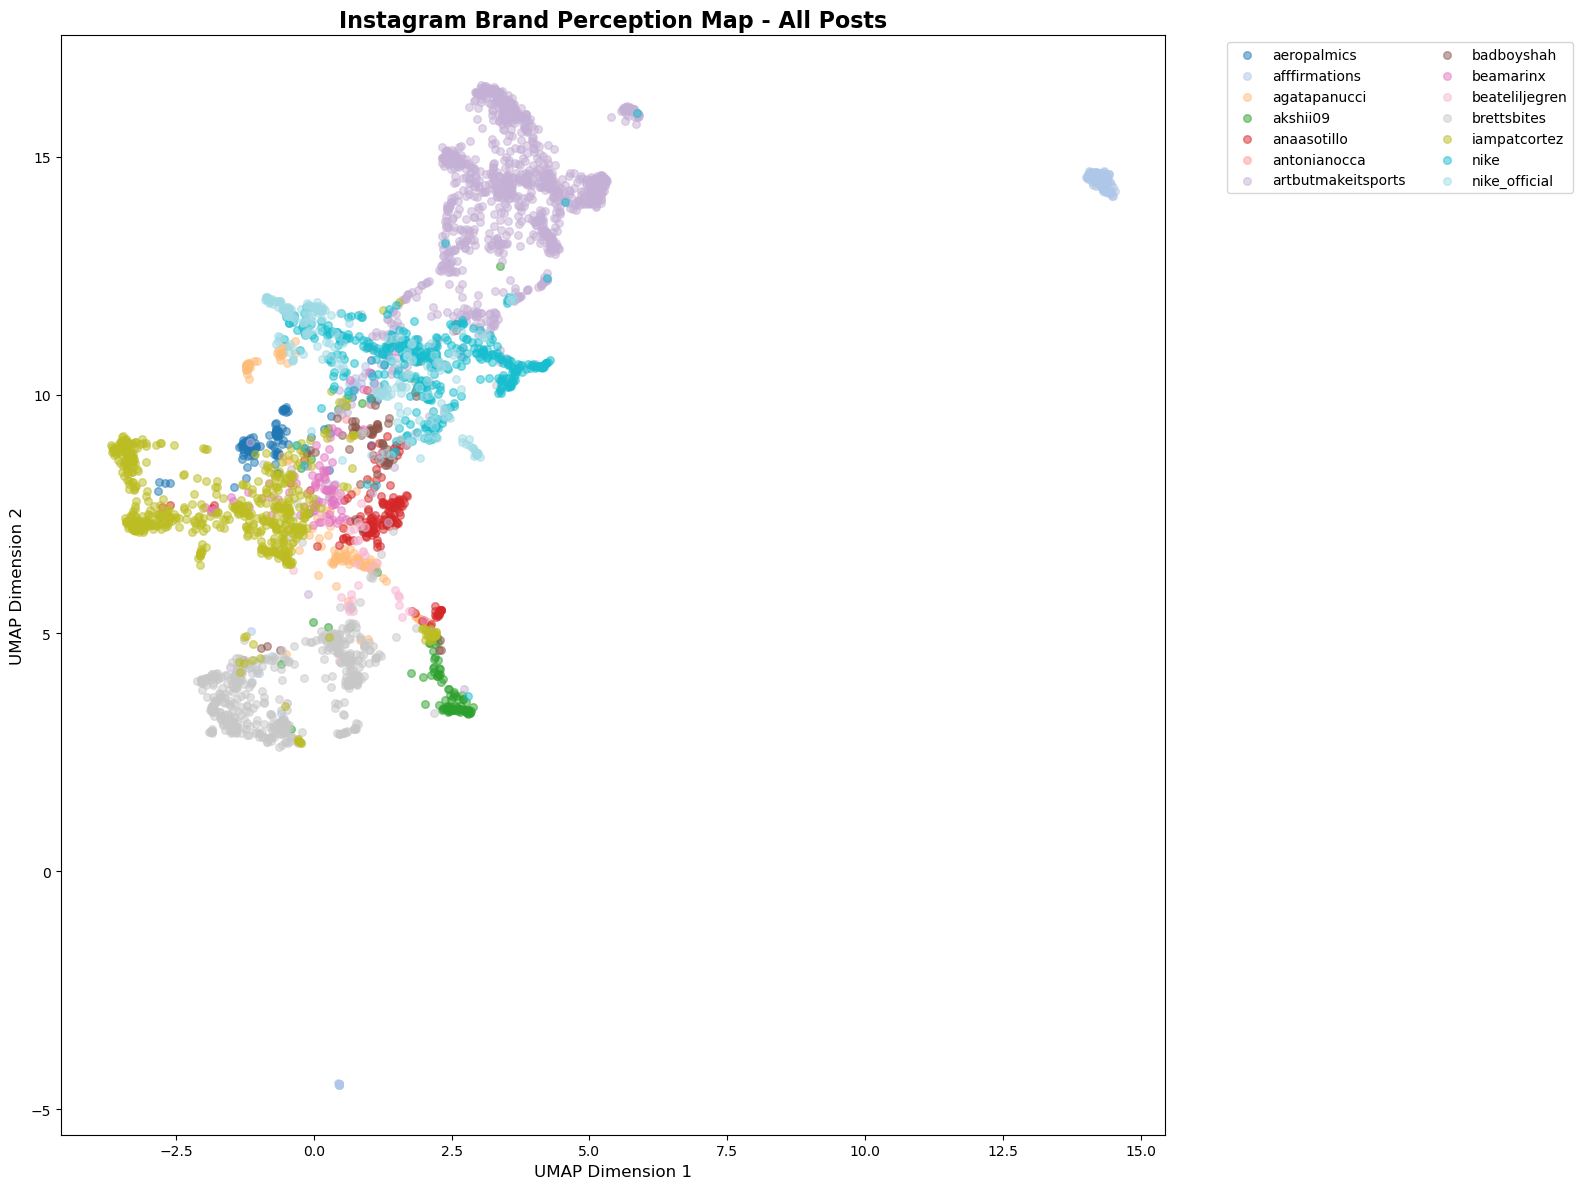

✓ Saved: perception_map_all_posts.png
Note: '_official' suffix indicates official ad content


In [27]:
# Visualization 1: Scatter plot with all posts colored by brand
plt.figure(figsize=(16, 12))

# Get unique brands and assign colors
unique_brands = df['brand'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_brands)))
brand_color_map = dict(zip(unique_brands, colors))

# Plot each brand
for brand in unique_brands:
    brand_df = df[df['brand'] == brand]
    plt.scatter(brand_df['x'], brand_df['y'], 
               alpha=0.5, s=30, 
               color=brand_color_map[brand],
               label=brand)

plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.title('Instagram Brand Perception Map - All Posts', fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.tight_layout()
plt.savefig(BASE_DIR / 'perception_map_all_posts.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: perception_map_all_posts.png")
print(f"Note: '_official' suffix indicates official ad content")

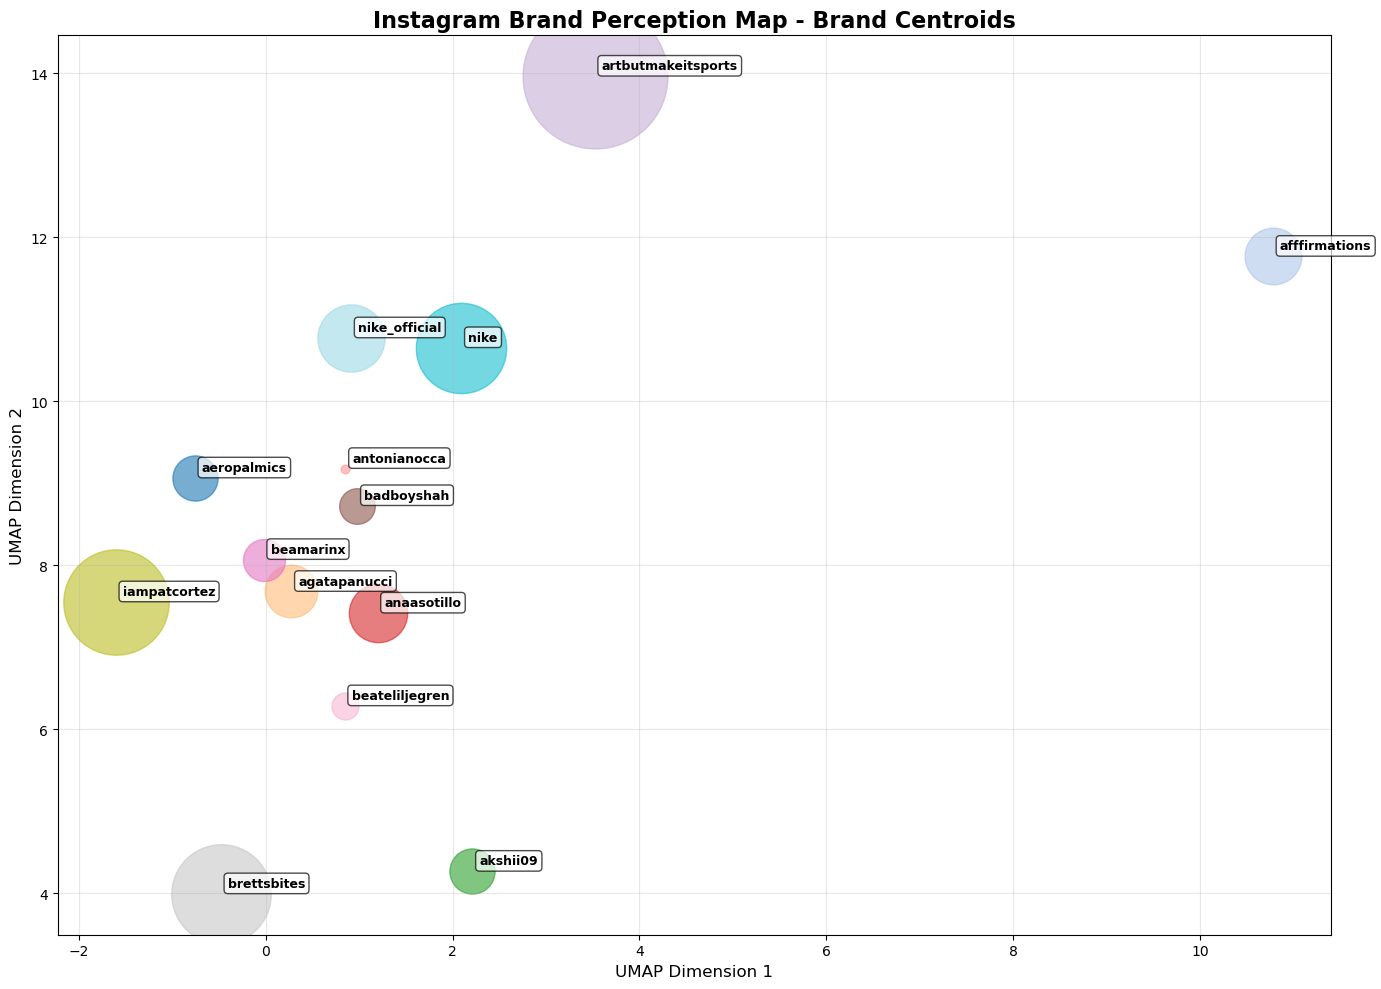

✓ Saved: perception_map_centroids.png


In [28]:
# Visualization 2: Brand centroids only with labels
plt.figure(figsize=(14, 10))

# Plot centroids
for _, row in brand_centroids.iterrows():
    plt.scatter(row['centroid_x'], row['centroid_y'], 
               s=row['post_count']*10,  # Size by post count
               alpha=0.6, 
               color=brand_color_map[row['brand']])
    
    # Add brand label
    plt.annotate(row['brand'], 
                (row['centroid_x'], row['centroid_y']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.title('Instagram Brand Perception Map - Brand Centroids', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(BASE_DIR / 'perception_map_centroids.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: perception_map_centroids.png")

In [ ]:
# Visualization 3: Interactive Plotly visualization
fig = px.scatter(df, x='x', y='y', color='brand',
                hover_data=['post_id', 'num_media'],
                title='Instagram Brand Perception Map (Interactive)',
                width=1200, height=800,
                opacity=0.6)

# Add centroids as larger markers
fig.add_trace(go.Scatter(
    x=brand_centroids['centroid_x'],
    y=brand_centroids['centroid_y'],
    mode='markers+text',
    marker=dict(size=brand_centroids['post_count']*2, 
                color='black',
                line=dict(width=2, color='white')),
    text=brand_centroids['brand'],
    textposition='top center',
    textfont=dict(size=10, color='black'),
    name='Brand Centroids',
    hovertemplate='<b>%{text}</b><br>Posts: %{marker.size}<extra></extra>'
))

fig.update_layout(
    xaxis_title='UMAP Dimension 1',
    yaxis_title='UMAP Dimension 2',
    font=dict(size=12),
    showlegend=True
)

fig.write_html(BASE_DIR / 'perception_map_interactive.html')
fig.show()

print("✓ Saved: perception_map_interactive.html")

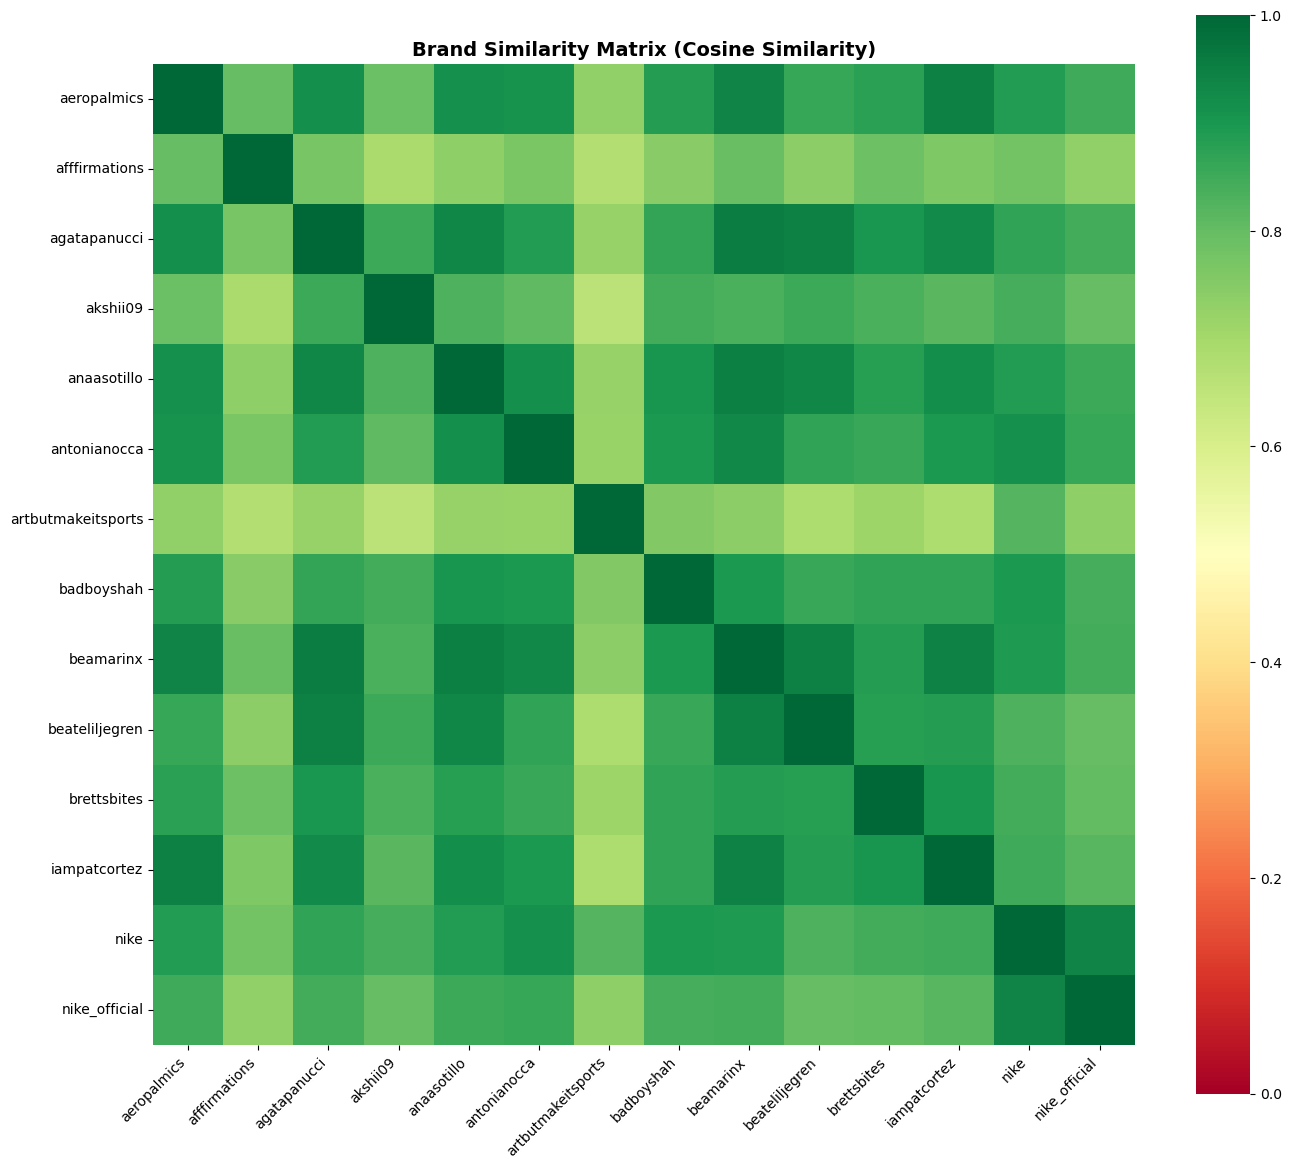

✓ Saved: brand_similarity_matrix.png


In [29]:
# Calculate brand similarity matrix (cosine similarity between centroids)
from sklearn.metrics.pairwise import cosine_similarity

# Get average embeddings for each brand
brand_avg_embeddings = {}
for brand in unique_brands:
    brand_indices = [i for i, b in enumerate(brands_list) if b == brand]
    brand_embeddings = embedding_matrix[brand_indices]
    brand_avg_embeddings[brand] = np.mean(brand_embeddings, axis=0)

# Create similarity matrix
brands_sorted = sorted(brand_avg_embeddings.keys())
brand_vectors = np.array([brand_avg_embeddings[b] for b in brands_sorted])
similarity_matrix = cosine_similarity(brand_vectors)

# Visualize as heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(similarity_matrix, 
            xticklabels=brands_sorted,
            yticklabels=brands_sorted,
            cmap='RdYlGn',
            vmin=0, vmax=1,
            annot=False,
            fmt='.2f',
            square=True)
plt.title('Brand Similarity Matrix (Cosine Similarity)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(BASE_DIR / 'brand_similarity_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: brand_similarity_matrix.png")

In [30]:
# Find most similar and dissimilar brand pairs
brand_pairs = []
n_brands = len(brands_sorted)
for i in range(n_brands):
    for j in range(i+1, n_brands):
        brand_pairs.append({
            'brand1': brands_sorted[i],
            'brand2': brands_sorted[j],
            'similarity': similarity_matrix[i, j]
        })

pairs_df = pd.DataFrame(brand_pairs).sort_values('similarity', ascending=False)

print("\n🔝 Top 10 Most Similar Brand Pairs:")
print(pairs_df.head(10).to_string(index=False))

print("\n🔻 Top 10 Most Dissimilar Brand Pairs:")
print(pairs_df.tail(10).to_string(index=False))

# Save to CSV
pairs_df.to_csv(BASE_DIR / 'brand_similarity_pairs.csv', index=False)
print("\n✓ Saved: brand_similarity_pairs.csv")


🔝 Top 10 Most Similar Brand Pairs:
      brand1         brand2  similarity
agatapanucci      beamarinx    0.956070
 anaasotillo      beamarinx    0.953039
 aeropalmics   iampatcortez    0.948915
   beamarinx beateliljegren    0.947178
agatapanucci beateliljegren    0.946825
   beamarinx   iampatcortez    0.943763
        nike  nike_official    0.940705
 aeropalmics      beamarinx    0.939059
agatapanucci    anaasotillo    0.936760
 anaasotillo beateliljegren    0.936132

🔻 Top 10 Most Dissimilar Brand Pairs:
            brand1             brand2  similarity
     afffirmations      nike_official    0.732586
       anaasotillo artbutmakeitsports    0.723271
      agatapanucci artbutmakeitsports    0.722906
      antonianocca artbutmakeitsports    0.719557
artbutmakeitsports        brettsbites    0.712021
     afffirmations           akshii09    0.689291
artbutmakeitsports     beateliljegren    0.686146
artbutmakeitsports       iampatcortez    0.684275
     afffirmations artbutmakeitspor

In [ ]:
# Save summary statistics
summary_stats = {
    'total_brands': len(unique_brands),
    'total_posts': len(df),
    'total_media_items': df['num_media'].sum(),
    'avg_posts_per_brand': df.groupby('brand').size().mean(),
    'avg_media_per_post': df['num_media'].mean(),
    'brands': brands_sorted,
    'posts_per_brand': df['brand'].value_counts().to_dict()
}

with open(BASE_DIR / 'perception_map_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)

print("\n📊 Summary Statistics:")
print(f"  Total brands: {summary_stats['total_brands']}")
print(f"  Total posts: {summary_stats['total_posts']}")
print(f"  Total media items: {summary_stats['total_media_items']}")
print(f"  Avg posts per brand: {summary_stats['avg_posts_per_brand']:.1f}")
print(f"  Avg media per post: {summary_stats['avg_media_per_post']:.1f}")
print("\n✓ Saved: perception_map_summary.json")

In [ ]:
# Export final results DataFrame
df.to_csv(BASE_DIR / 'perception_map_data.csv', index=False)
brand_centroids.to_csv(BASE_DIR / 'brand_centroids.csv', index=False)

print("✓ Saved: perception_map_data.csv")
print("✓ Saved: brand_centroids.csv")
print("\n" + "="*60)
print("🎉 PERCEPTION MAP ANALYSIS COMPLETE!")
print("="*60)
print("\nGenerated files:")
print("  - perception_map_all_posts.png")
print("  - perception_map_centroids.png")
print("  - perception_map_interactive.html")
print("  - brand_similarity_matrix.png")
print("  - brand_similarity_pairs.csv")
print("  - perception_map_data.csv")
print("  - brand_centroids.csv")
print("  - perception_map_summary.json")
print("  - _embeddings_cache.json (cached embeddings)")
print("  - _post_embeddings.npz (post embeddings)")
print("  - Individual .npy files for each media item")